# Importing all necessary libraries

In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import calendar
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from pyproj import Geod
from geopy.geocoders import Nominatim
import time
from pprint import pprint
import warnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
import os
import math
from pathlib import Path

from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import (
    mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve, average_precision_score
)
from sklearn import ensemble, linear_model, neighbors, tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn import model_selection, tree, linear_model, neighbors, naive_bayes, ensemble

# Data Inspection and Cleaning

### Reading the data files

In [2]:
train_data = pd.read_csv(r'C://Users//HP//OneDrive//Documents//Data Science Semester Project//train.csv')
test_data = pd.read_csv(r'C://Users//HP//OneDrive//Documents//Data Science Semester Project//test.csv')
submission_data = pd.read_csv(r'C://Users//HP//OneDrive//Documents//Data Science Semester Project//sample_submission.csv')

### Features datat types

In [3]:
print(train_data.dtypes)
print(test_data.dtypes)

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object
id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object


### Sample of our train_data

In [4]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Statistical Describtion of Data

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


### Removing rows that contain passenger_count == 0,7,8 or 9

In [6]:
train_data.drop(train_data.index[train_data['passenger_count'] == 0], inplace = True)
#train_data.drop(train_data.index[train_data['passenger_count'] == 7], inplace = True)
#train_data.drop(train_data.index[train_data['passenger_count'] == 8], inplace = True)
#train_data.drop(train_data.index[train_data['passenger_count'] == 9], inplace = True)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458584 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458584 non-null  object 
 1   vendor_id           1458584 non-null  int64  
 2   pickup_datetime     1458584 non-null  object 
 3   dropoff_datetime    1458584 non-null  object 
 4   passenger_count     1458584 non-null  int64  
 5   pickup_longitude    1458584 non-null  float64
 6   pickup_latitude     1458584 non-null  float64
 7   dropoff_longitude   1458584 non-null  float64
 8   dropoff_latitude    1458584 non-null  float64
 9   store_and_fwd_flag  1458584 non-null  object 
 10  trip_duration       1458584 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 133.5+ MB


In [8]:
train_data["trip_duraion"] =  np.log(train_data["trip_duration"])
mean = np.mean(train_data["trip_duration"])
std = np.std(train_data["trip_duration"])
train_data = train_data[train_data['trip_duration'] <= mean + 2*std]
train_data = train_data[train_data['trip_duration'] >= mean - 2*std]

### Note: After searching we found that the boarders of NYC in cordinates (lat.., long..) is: -74.03, -73.75 for longitude and 40.63, 40.85 for latitude, So let's clean our Data according to this information

In [9]:
train_data = train_data[train_data['pickup_longitude'] <= -73.75]
train_data = train_data[train_data['pickup_longitude'] >= -74.03]
train_data = train_data[train_data['pickup_latitude'] <= 40.85]
train_data = train_data[train_data['pickup_latitude'] >= 40.63]
train_data = train_data[train_data['dropoff_longitude'] <= -73.75]
train_data = train_data[train_data['dropoff_longitude'] >= -74.03]
train_data = train_data[train_data['dropoff_latitude'] <= 40.85]
train_data = train_data[train_data['dropoff_latitude'] >= 40.63]

In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_duraion
count,1437076.000,1437076.000,1437076.000,1437076.000,1437076.000,1437076.000,1437076.000,1437076.000
mean,1.534,1.664,-73.974,40.751,-73.974,40.752,824.448,6.447
std,0.499,1.314,0.037,0.027,0.033,0.030,644.681,0.770
min,1.000,1.000,-74.030,40.630,-74.030,40.630,1.000,0.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,394.000,5.976
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,655.000,6.485
75%,2.000,2.000,-73.968,40.768,-73.963,40.770,1056.000,6.962
max,2.000,6.000,-73.751,40.850,-73.750,40.850,11411.000,9.342


###  Now let's see our train_data after cleaning

In [11]:
train_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duraion
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,6.120
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,6.497
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,7.661
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,6.061
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,6.075
...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982,40.746,-73.995,40.740,N,778,6.657
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.001,40.747,-73.970,40.797,N,655,6.485
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959,40.769,-74.004,40.707,N,764,6.639
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982,40.749,-73.975,40.757,N,373,5.922


# 2.

# EDA

### Spliting our data

In [12]:
from sklearn.model_selection import train_test_split
# first separate the labels from the features
y = train_data['trip_duration']
X = train_data.drop('trip_duration', axis=1)
# define the number of examples in the validation and test sets
orig_size = len(X)
heldout_size = int(orig_size * 0.2)
# take a test set (20% of the data). To get the same result each time, set a random state
X, X_test, y, y_test = train_test_split(X, y, test_size=heldout_size, random_state=123)
# now split the remaining data into a training and a validation set. 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=heldout_size, random_state=123)

In [13]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape

((862246, 11), (287415, 11), (287415, 11), (862246,))

In [14]:
X_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duraion
count,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000
mean,1.534,1.664,-73.974,40.751,-73.974,40.752,6.448
std,0.499,1.313,0.037,0.027,0.033,0.030,0.770
min,1.000,1.000,-74.030,40.630,-74.030,40.630,0.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,5.976
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,6.485
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,6.962
max,2.000,6.000,-73.751,40.850,-73.750,40.850,9.342


# Histgram of the trip_duration and for scaled trip_duration

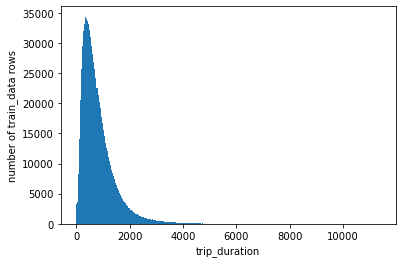

In [15]:
y_train.plot(kind='hist', bins=300);
plt.xlabel("trip_duration")
plt.ylabel('number of train_data rows')
plt.show()

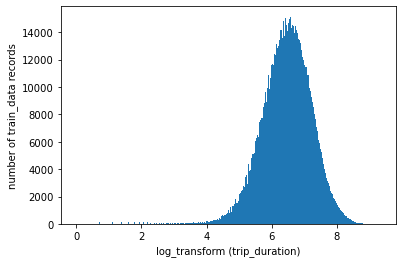

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


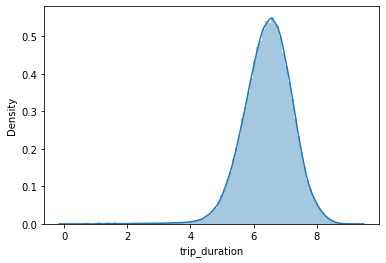

In [16]:
plt.hist(np.log(y_train), bins=300)
plt.xlabel('log_transform (trip_duration)')
plt.ylabel('number of train_data records')
plt.show()
sns.distplot(np.log(y_train), bins =100)

# Respective MEAN trip durations

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

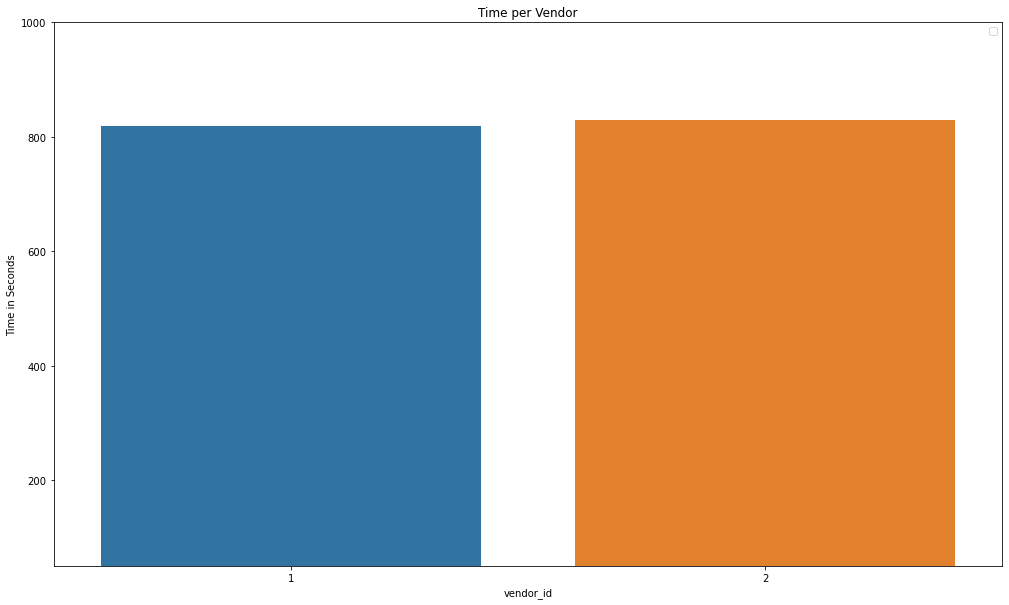

In [17]:
warnings.filterwarnings("ignore")
plot_vendor = train_data.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10));
plt.ylim(ymin=50)
plt.ylim(ymax=1000)
sns.barplot(plot_vendor.index,plot_vendor.values);
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

# `store_and_fwd_flag`

No handles with labels found to put in legend.


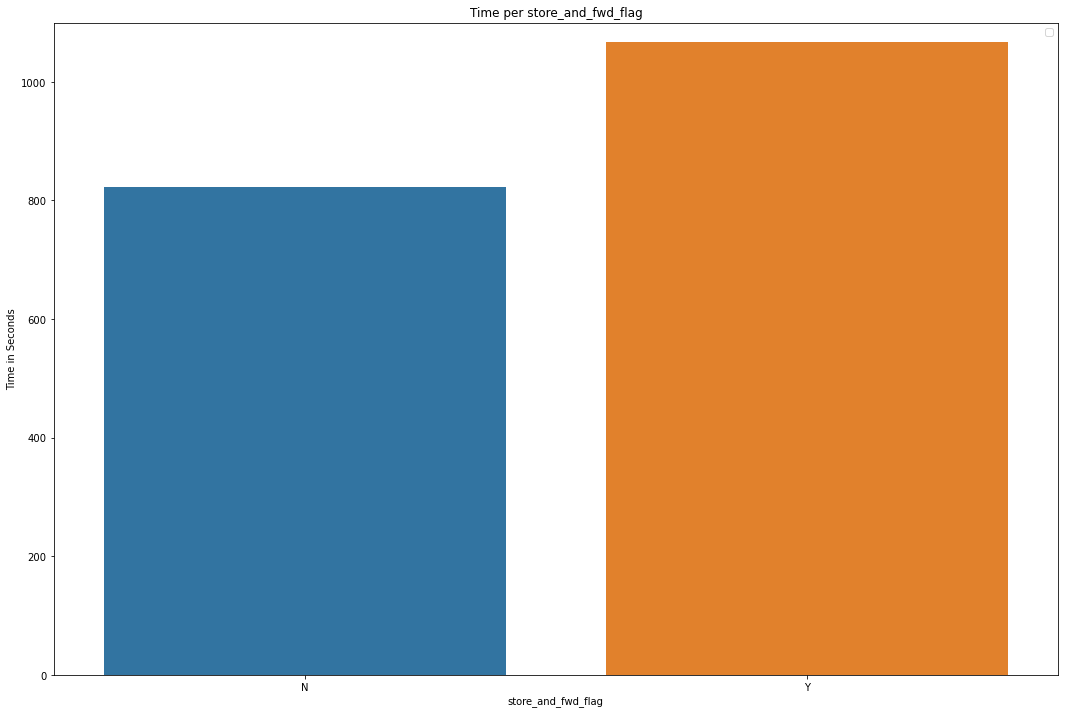

In [18]:
flag = train_data.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(18,12))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(flag.index,flag.values)

# Group the MEAN travel times by the passenger_count

No handles with labels found to put in legend.


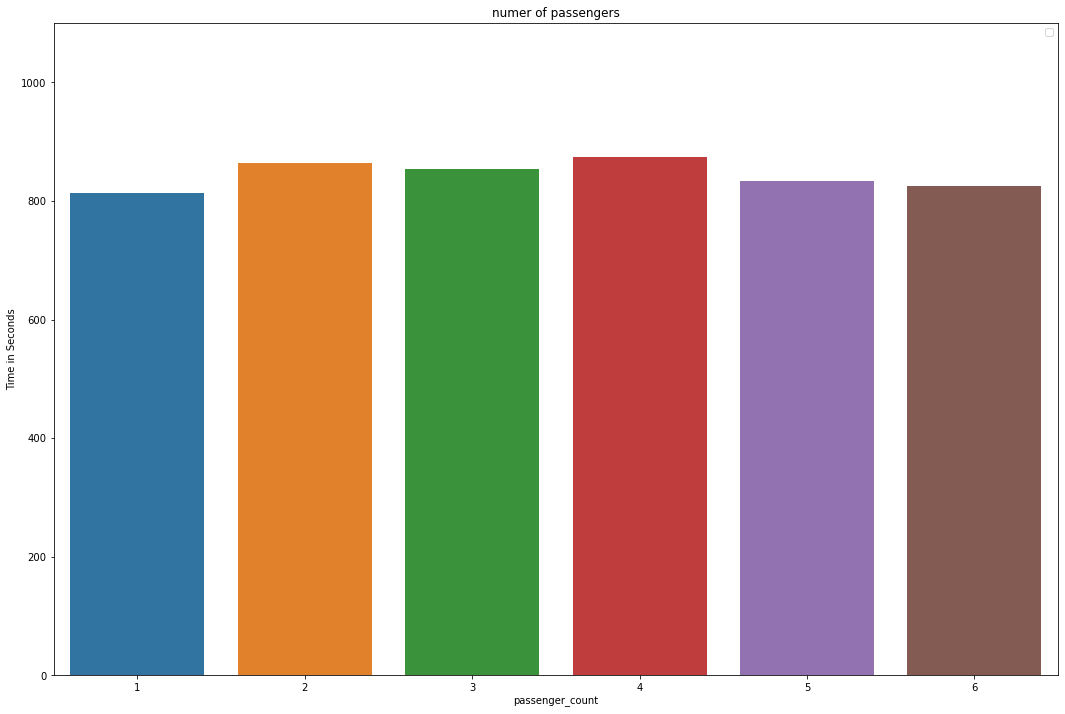

In [19]:
passenger_count = train_data.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(18,12))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('numer of passengers')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(passenger_count.index,passenger_count.values)

# Feature Engineering

In [20]:
X_train['pickup_datetime'] = pd.to_datetime(X_train.pickup_datetime)
X_valid['pickup_datetime'] = pd.to_datetime(X_valid.pickup_datetime)
X_test ['pickup_datetime']  =  pd.to_datetime(X_test.pickup_datetime)

X_train.loc[:, 'pickup_date'] = X_train['pickup_datetime'].dt.date
X_valid.loc[:, 'pickup_date'] = X_valid['pickup_datetime'].dt.date
X_test.loc [:, 'pickup_date'] = X_test ['pickup_datetime'].dt.date

X_train['dropoff_datetime'] = pd.to_datetime(X_train.dropoff_datetime)
X_valid['dropoff_datetime'] = pd.to_datetime(X_valid.dropoff_datetime)
X_test ['dropoff_datetime'] = pd.to_datetime(X_test.dropoff_datetime)

### Functions to get  Haversine Distance, Bearing Distance and manhattan_distance

In [21]:
# 1 Haversine Distance
def haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# 2 Bearing Distance 
def bearing_direction(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# 3 Manhattan Distance
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_distance(lat1, lng1, lat1, lng2)
    b = haversine_distance(lat1, lng1, lat2, lng1)
    return a + b

In [22]:
X_train.loc[:, 'distance_haversine'] = haversine_distance(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values, X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)
X_valid.loc[:, 'distance_haversine'] = haversine_distance(X_valid['pickup_latitude'].values, X_valid['pickup_longitude'].values, X_valid['dropoff_latitude'].values, X_valid['dropoff_longitude'].values)
X_test.loc[:, 'distance_haversine'] = haversine_distance(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values, X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)

In [23]:
X_train.loc[:, "direction"] = bearing_direction(X_train["pickup_latitude"].values, X_train["pickup_longitude"].values, X_train["dropoff_latitude"].values, X_train["dropoff_longitude"].values)
X_valid.loc[:, "direction"] = bearing_direction(X_valid["pickup_latitude"].values, X_valid["pickup_longitude"].values, X_valid["dropoff_latitude"].values, X_valid["dropoff_longitude"].values)
X_test.loc[:, "direction"] = bearing_direction(X_test["pickup_latitude"].values, X_test["pickup_longitude"].values, X_test["dropoff_latitude"].values, X_test["dropoff_longitude"].values)

In [24]:
X_train.loc[:, "manhattan_distance"] =  manhattan_distance(X_train["pickup_latitude"].values, X_train["pickup_longitude"].values, X_train["dropoff_latitude"].values, X_train["dropoff_longitude"].values)
X_valid.loc[:, "manhattan_distance"] =  manhattan_distance(X_valid["pickup_latitude"].values, X_valid["pickup_longitude"].values, X_valid["dropoff_latitude"].values, X_valid["dropoff_longitude"].values)
X_test.loc[:, "manhattan_distance"] =   manhattan_distance(X_test["pickup_latitude"].values, X_test["pickup_longitude"].values, X_test["dropoff_latitude"].values, X_test["dropoff_longitude"].values)

In [25]:
X_train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duraion,pickup_date,distance_haversine,direction,manhattan_distance
575518,id0288353,1,2016-02-07 00:33:39,2016-02-07 00:48:24,1,-74.005,40.741,-73.975,40.747,N,6.786,2016-02-07,2.659,74.428,3.276
1042450,id3384872,2,2016-06-03 20:59:12,2016-06-03 21:19:12,1,-73.987,40.739,-74.010,40.711,N,7.090,2016-06-03,3.723,-149.217,5.103
1374913,id2796899,1,2016-03-04 21:02:25,2016-03-04 21:14:55,2,-73.985,40.752,-73.998,40.733,N,6.620,2016-03-04,2.379,-152.847,3.203
1085237,id3262203,1,2016-04-10 07:16:52,2016-04-10 07:22:39,1,-73.990,40.757,-73.978,40.753,N,5.849,2016-04-10,1.087,109.917,1.392
665420,id3978351,2,2016-03-28 14:13:35,2016-03-28 14:22:13,1,-73.994,40.751,-73.988,40.765,N,6.250,2016-03-28,1.703,19.114,2.167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299258,id2507138,2,2016-06-10 08:14:18,2016-06-10 08:34:50,1,-74.007,40.704,-73.994,40.736,N,7.116,2016-06-10,3.683,17.409,4.616
398277,id1885968,2,2016-05-30 15:58:55,2016-05-30 16:15:55,5,-73.993,40.737,-73.954,40.779,N,6.928,2016-05-30,5.745,35.245,8.009
980612,id2969364,2,2016-06-11 09:52:49,2016-06-11 09:59:52,6,-73.989,40.749,-73.987,40.761,N,6.047,2016-06-11,1.316,6.392,1.454
407792,id1331542,2,2016-01-04 20:33:15,2016-01-04 20:40:03,1,-73.975,40.742,-74.013,40.702,N,6.011,2016-01-04,5.516,-144.477,7.693


In [26]:
X_valid

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duraion,pickup_date,distance_haversine,direction,manhattan_distance
880326,id3074203,1,2016-06-15 20:45:20,2016-06-15 20:55:39,1,-73.968,40.759,-73.988,40.741,N,6.428,2016-06-15,2.589,-139.989,3.648
59215,id1798030,2,2016-02-25 09:07:54,2016-02-25 09:11:50,1,-73.962,40.773,-73.959,40.781,N,5.464,2016-02-25,0.958,18.895,1.217
1403088,id3199598,1,2016-02-27 14:48:21,2016-02-27 15:01:25,1,-73.991,40.740,-73.988,40.720,N,6.664,2016-02-27,2.194,174.536,2.393
837328,id2126715,1,2016-06-02 09:43:47,2016-06-02 10:02:19,1,-73.979,40.763,-73.952,40.774,N,7.014,2016-06-02,2.606,60.960,3.544
852561,id1113358,1,2016-06-28 14:23:47,2016-06-28 14:38:24,1,-73.978,40.759,-73.985,40.736,N,6.777,2016-06-28,2.585,-165.689,3.143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978363,id0886345,2,2016-04-15 09:46:25,2016-04-15 10:01:12,5,-73.996,40.745,-73.982,40.729,N,6.788,2016-04-15,2.121,146.063,2.944
793283,id1521611,2,2016-04-20 19:05:09,2016-04-20 19:15:36,1,-73.991,40.733,-73.991,40.750,N,6.441,2016-04-20,1.875,-0.707,1.898
499136,id1658124,1,2016-04-13 00:38:50,2016-04-13 00:41:12,1,-74.009,40.716,-74.005,40.713,N,4.956,2016-04-13,0.444,127.523,0.623
1206015,id3113079,1,2016-05-29 22:10:56,2016-05-29 22:19:50,1,-73.936,40.820,-73.947,40.800,N,6.280,2016-05-29,2.450,-158.534,3.176


### Extracting some useful information from datetime variables

In [27]:
X_train['Month'] = X_train['pickup_datetime'].dt.month
X_valid['Month'] = X_valid['pickup_datetime'].dt.month
X_test['Month'] = X_test['pickup_datetime'].dt.month

X_train["Day"] = X_train.pickup_datetime.dt.day
X_valid["Day"] = X_valid.pickup_datetime.dt.day
X_test["Day"] = X_test.pickup_datetime.dt.day

X_train["Hour"] = X_train.pickup_datetime.dt.hour
X_valid["Hour"] = X_valid.pickup_datetime.dt.hour
X_test["Hour"] = X_test.pickup_datetime.dt.hour

X_train["Week"] = X_train.pickup_datetime.dt.week
X_valid["Week"] = X_valid.pickup_datetime.dt.week
X_test["Week"] = X_test.pickup_datetime.dt.week

X_train["Day_week"] = X_train["pickup_datetime"].dt.dayofweek
X_valid["Day_week"] = X_valid["pickup_datetime"].dt.dayofweek
X_test["Day_week"] = X_test["pickup_datetime"].dt.dayofweek

In [28]:
X_train = pd.get_dummies(X_train, columns=['store_and_fwd_flag'])
X_valid = pd.get_dummies(X_valid, columns=['store_and_fwd_flag'])
X_test = pd.get_dummies(X_test, columns=['store_and_fwd_flag'])

In [29]:
X_train['store_and_fwd_flag_N'] = X_train['store_and_fwd_flag_N'].astype(np.int64)
X_valid['store_and_fwd_flag_N'] = X_valid['store_and_fwd_flag_N'].astype(np.int64)
X_test['store_and_fwd_flag_N'] = X_test['store_and_fwd_flag_N'].astype(np.int64)

X_train['store_and_fwd_flag_Y'] = X_train['store_and_fwd_flag_Y'].astype(np.int64)
X_valid['store_and_fwd_flag_Y'] = X_valid['store_and_fwd_flag_Y'].astype(np.int64)
X_test['store_and_fwd_flag_Y'] = X_test['store_and_fwd_flag_Y'].astype(np.int64)

### Drop some Features that isn't important to our model

In [30]:
X_train.drop("id", axis=1, inplace=True)
X_train.drop("vendor_id", axis=1, inplace=True)
X_train.drop("Week", axis=1, inplace=True)

X_valid.drop("id", axis=1, inplace=True)
X_valid.drop("vendor_id", axis=1, inplace=True)
X_valid.drop("Week", axis=1, inplace=True)

X_test.drop("id", axis=1, inplace=True)
X_test.drop("vendor_id", axis=1, inplace=True)
X_test.drop("Week", axis=1, inplace=True)

In [31]:
X_train.drop("pickup_date", axis=1, inplace=True)
X_valid.drop("pickup_date", axis=1, inplace=True)
X_test.drop("pickup_date", axis=1, inplace=True)
X_train.dtypes

pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
passenger_count                  int64
pickup_longitude               float64
pickup_latitude                float64
dropoff_longitude              float64
dropoff_latitude               float64
trip_duraion                   float64
distance_haversine             float64
direction                      float64
manhattan_distance             float64
Month                            int64
Day                              int64
Hour                             int64
Day_week                         int64
store_and_fwd_flag_N             int64
store_and_fwd_flag_Y             int64
dtype: object

### Check if the trip day is a national holiday or near_holiday day

In [32]:
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

X_train['pickup_holiday'] = pd.to_datetime(X_train.pickup_datetime.dt.date).isin(holidays)
X_train['pickup_holiday'] = X_train.pickup_holiday.map(lambda x: 1 if x == True else 0)
X_train['pickup_near_holiday'] = (pd.to_datetime(X_train.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(X_train.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
X_train['pickup_near_holiday'] = X_train.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

In [33]:
X_test['pickup_holiday'] = pd.to_datetime(X_test.pickup_datetime.dt.date).isin(holidays)
X_test['pickup_holiday'] = X_test.pickup_holiday.map(lambda x: 1 if x == True else 0)
X_test['pickup_near_holiday'] = (pd.to_datetime(X_test.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(X_test.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
X_test['pickup_near_holiday'] = X_test.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

In [34]:
X_valid['pickup_holiday'] = pd.to_datetime(X_valid.pickup_datetime.dt.date).isin(holidays)
X_valid['pickup_holiday'] = X_valid.pickup_holiday.map(lambda x: 1 if x == True else 0)
X_valid['pickup_near_holiday'] = (pd.to_datetime(X_valid.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(X_valid.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
X_valid['pickup_near_holiday'] = X_valid.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862246 entries, 575518 to 912281
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   pickup_datetime       862246 non-null  datetime64[ns]
 1   dropoff_datetime      862246 non-null  datetime64[ns]
 2   passenger_count       862246 non-null  int64         
 3   pickup_longitude      862246 non-null  float64       
 4   pickup_latitude       862246 non-null  float64       
 5   dropoff_longitude     862246 non-null  float64       
 6   dropoff_latitude      862246 non-null  float64       
 7   trip_duraion          862246 non-null  float64       
 8   distance_haversine    862246 non-null  float64       
 9   direction             862246 non-null  float64       
 10  manhattan_distance    862246 non-null  float64       
 11  Month                 862246 non-null  int64         
 12  Day                   862246 non-null  int64         

In [36]:
X_train

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duraion,distance_haversine,direction,manhattan_distance,Month,Day,Hour,Day_week,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_holiday,pickup_near_holiday
575518,2016-02-07 00:33:39,2016-02-07 00:48:24,1,-74.005,40.741,-73.975,40.747,6.786,2.659,74.428,3.276,2,7,0,6,1,0,0,0
1042450,2016-06-03 20:59:12,2016-06-03 21:19:12,1,-73.987,40.739,-74.010,40.711,7.090,3.723,-149.217,5.103,6,3,20,4,1,0,0,0
1374913,2016-03-04 21:02:25,2016-03-04 21:14:55,2,-73.985,40.752,-73.998,40.733,6.620,2.379,-152.847,3.203,3,4,21,4,1,0,0,0
1085237,2016-04-10 07:16:52,2016-04-10 07:22:39,1,-73.990,40.757,-73.978,40.753,5.849,1.087,109.917,1.392,4,10,7,6,1,0,0,0
665420,2016-03-28 14:13:35,2016-03-28 14:22:13,1,-73.994,40.751,-73.988,40.765,6.250,1.703,19.114,2.167,3,28,14,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299258,2016-06-10 08:14:18,2016-06-10 08:34:50,1,-74.007,40.704,-73.994,40.736,7.116,3.683,17.409,4.616,6,10,8,4,1,0,0,0
398277,2016-05-30 15:58:55,2016-05-30 16:15:55,5,-73.993,40.737,-73.954,40.779,6.928,5.745,35.245,8.009,5,30,15,0,1,0,1,0
980612,2016-06-11 09:52:49,2016-06-11 09:59:52,6,-73.989,40.749,-73.987,40.761,6.047,1.316,6.392,1.454,6,11,9,5,1,0,0,0
407792,2016-01-04 20:33:15,2016-01-04 20:40:03,1,-73.975,40.742,-74.013,40.702,6.011,5.516,-144.477,7.693,1,4,20,0,1,0,0,0


In [37]:
X_train.drop("pickup_datetime", axis=1, inplace=True)
X_train.drop("dropoff_datetime", axis=1, inplace=True)
X_train.drop("pickup_longitude", axis=1, inplace=True)
X_train.drop("pickup_latitude", axis=1, inplace=True)
X_train.drop("dropoff_longitude", axis=1, inplace=True)
X_train.drop("dropoff_latitude", axis=1, inplace=True)



X_valid.drop("pickup_datetime", axis=1, inplace=True)
X_valid.drop("dropoff_datetime", axis=1, inplace=True)
X_valid.drop("pickup_longitude", axis=1, inplace=True)
X_valid.drop("pickup_latitude", axis=1, inplace=True)
X_valid.drop("dropoff_longitude", axis=1, inplace=True)
X_valid.drop("dropoff_latitude", axis=1, inplace=True)


X_test.drop("pickup_datetime", axis=1, inplace=True)
X_test.drop("dropoff_datetime", axis=1, inplace=True)
X_test.drop("pickup_longitude", axis=1, inplace=True)
X_test.drop("pickup_latitude", axis=1, inplace=True)
X_test.drop("dropoff_longitude", axis=1, inplace=True)
X_test.drop("dropoff_latitude", axis=1, inplace=True)

In [38]:
X_train = pd.get_dummies(X_train, columns=['Hour'])
X_valid = pd.get_dummies(X_valid, columns=['Hour'])
X_test = pd.get_dummies(X_test, columns=['Hour'])

In [39]:
X_train = pd.get_dummies(X_train, columns=['Month'])
X_valid = pd.get_dummies(X_valid, columns=['Month'])
X_test = pd.get_dummies(X_test, columns=['Month'])

In [40]:
X_train = pd.get_dummies(X_train, columns=['Day'])
X_valid = pd.get_dummies(X_valid, columns=['Day'])
X_test = pd.get_dummies(X_test, columns=['Day'])

In [41]:
X_train = pd.get_dummies(X_train, columns=['Day_week'])
X_valid = pd.get_dummies(X_valid, columns=['Day_week'])
X_test = pd.get_dummies(X_test, columns=['Day_week'])

In [42]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train[["manhattan_distance"]] = scaler.fit_transform(X_train[["manhattan_distance"]])
X_train[["distance_haversine"]] = scaler.fit_transform(X_train[["distance_haversine"]])
X_train[["direction"]] = scaler.fit_transform(X_train[["direction"]])

In [43]:
X_valid[["manhattan_distance"]] = scaler.fit_transform(X_valid[["manhattan_distance"]])
X_valid[["distance_haversine"]] = scaler.fit_transform(X_valid[["distance_haversine"]])
X_valid[["direction"]] = scaler.fit_transform(X_valid[["direction"]])

In [44]:
X_test[["manhattan_distance"]] = scaler.fit_transform(X_test[["manhattan_distance"]])
X_test[["distance_haversine"]] = scaler.fit_transform(X_test[["distance_haversine"]])
X_test[["direction"]] = scaler.fit_transform(X_test[["direction"]])

In [45]:
X_train

,passenger_count,trip_duraion,distance_haversine,direction,manhattan_distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_holiday,pickup_near_holiday,Hour_0,...,Day_29,Day_30,Day_31,Day_week_0,Day_week_1,Day_week_2,Day_week_3,Day_week_4,Day_week_5,Day_week_6
575518,1,6.786,0.100,0.707,0.090,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1042450,1,7.090,0.140,0.085,0.140,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1374913,2,6.620,0.089,0.075,0.088,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1085237,1,5.849,0.041,0.805,0.038,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
665420,1,6.250,0.064,0.553,0.059,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299258,1,7.116,0.138,0.548,0.126,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
398277,5,6.928,0.216,0.598,0.219,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
980612,6,6.047,0.049,0.518,0.040,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
407792,1,6.011,0.207,0.099,0.210,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [46]:
X_train.describe()

,passenger_count,trip_duraion,distance_haversine,direction,manhattan_distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_holiday,pickup_near_holiday,Hour_0,...,Day_29,Day_30,Day_31,Day_week_0,Day_week_1,Day_week_2,Day_week_3,Day_week_4,Day_week_5,Day_week_6
count,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,...,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000,862246.000
mean,1.664,6.448,0.124,0.456,0.117,0.995,0.005,0.019,0.036,0.036,...,0.032,0.027,0.016,0.129,0.139,0.144,0.150,0.153,0.151,0.134
std,1.313,0.770,0.138,0.291,0.134,0.074,0.074,0.135,0.186,0.186,...,0.176,0.162,0.124,0.335,0.346,0.351,0.357,0.360,0.358,0.340
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,5.976,0.046,0.150,0.043,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,6.485,0.078,0.522,0.073,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,2.000,6.962,0.142,0.650,0.133,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,6.000,9.342,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


# Modeling

## Using Ridge Regrission

In [47]:
from sklearn.linear_model import Ridge
##Initialise the model
ridge_baseline = Ridge(alpha=0.0001)
## Train the model on the training set
ridge_baseline.fit(X_train, y_train)

Ridge(alpha=0.0001)

In [48]:
score = ridge_baseline.score(X_valid, y_valid)
print(f"Validation R^2: {score : .4f}")
print(f"Training R^2: {ridge_baseline.score(X_train, y_train) : .4f}")

Validation R^2:  0.8267
Training R^2:  0.8262


In [49]:
alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]
scores = dict()

for alpha in alpha_values:
    ridge_baseline = Ridge(alpha=alpha)
    ridge_baseline.fit(X_train, y_train)
    scores[alpha] = ridge_baseline.score(X_valid, y_valid)
scores

{0.001: 0.8267045947373517,
 0.005: 0.8267045928299833,
 0.01: 0.8267045904354104,
 0.05: 0.8267045708647951,
 0.1: 0.8267045453686879,
 0.5: 0.8267043005451241,
 1.0: 0.8267038945656192}

In [50]:
preds =  ridge_baseline.predict(X_valid)
print(f"Pearson's correlation coefficient of predictions vs labels: {np.corrcoef(y_valid, preds)[0, 1] : .4f}")

Pearson's correlation coefficient of predictions vs labels:  0.9092


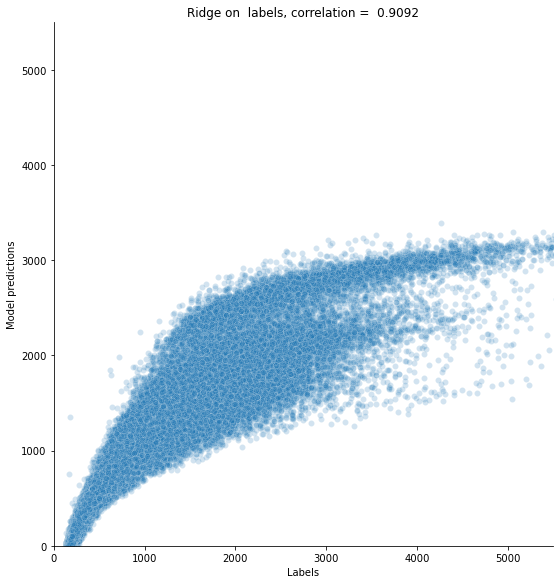

In [51]:
sns.relplot(x=y_valid, y=preds, alpha=0.2, height=8)
plt.xlabel('Labels')
plt.xlim(0, 5500)
plt.ylabel('Model predictions')
plt.ylim(0, 5500)
plt.title(f"Ridge on  labels, correlation = {np.corrcoef(y_valid, preds)[0, 1] : .4f}");

## Using Linear Regrission

In [52]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [53]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

Y_pred = model.predict(X_test)

In [54]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, Y_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, Y_pred))

Coefficients: [ 5.82629221e-01  4.90053531e+02  2.81965203e+03  1.70715455e+01
 -9.81497339e+02 -3.22987702e+13 -3.22987702e+13 -5.65309310e+01
 -3.85217706e+00  1.20472036e+13  1.20472036e+13  1.20472036e+13
  1.20472036e+13  1.20472036e+13  1.20472036e+13  1.20472036e+13
  1.20472036e+13  1.20472036e+13  1.20472036e+13  1.20472036e+13
  1.20472036e+13  1.20472036e+13  1.20472036e+13  1.20472036e+13
  1.20472036e+13  1.20472036e+13  1.20472036e+13  1.20472036e+13
  1.20472036e+13  1.20472036e+13  1.20472036e+13  1.20472036e+13
  1.20472036e+13 -1.06042472e+14 -1.06042472e+14 -1.06042472e+14
 -1.06042472e+14 -1.06042472e+14 -1.06042472e+14 -7.65849893e+12
 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12
 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12
 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12
 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12
 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12 -7.65849893e+12
 -7.6584989

In [55]:
r2_score(y_test, Y_pred)

0.8285304907651238

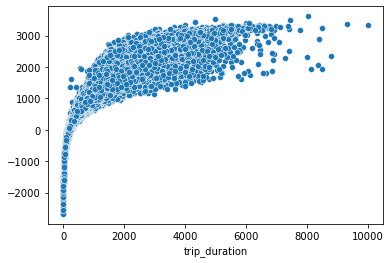

In [56]:
sns.scatterplot(y_test, Y_pred)

# We can see from the result that linear regrission is slightly better than Ridge regrission